# Imports

In [1]:
import sys
import math
import numpy as np
import pandas as pd
from scipy import stats
from decimal import Decimal
from matplotlib import pyplot as plt

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
</ol>

# Cluster 17

In [2]:
cluster = '17'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 191
Num noneffect sequences: 191
Num scores: 191


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]]))
                        / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]]))
                           / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]]))
                       - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['ism_score'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
print("Number of Unique SNPs: ", len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of Unique SNPs:  172


## Distribution of ISM Scores <a name='score_dist' />

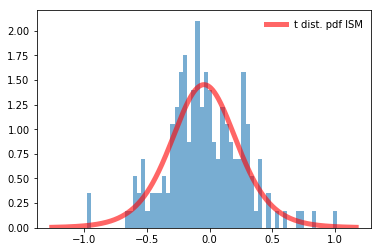

In [5]:
from scipy.stats import *
ism_scores = snps.ism_score.tolist()
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.001, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.999, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [6]:
print("Shape: ", ism_shape)
print("Mean: ", ism_mean)
print("Stdev: ", ism_stdev)
stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev])

Shape:  7.783371906757871
Mean:  -0.04472313370775455
Stdev:  0.2661580803275235


KstestResult(statistic=0.03957728166287111, pvalue=0.9504367834858697)

## Distribution of Delta Scores

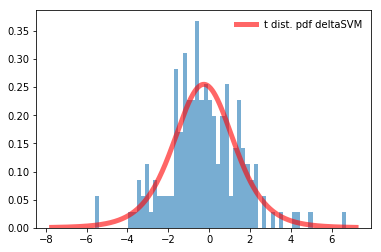

In [7]:
from scipy.stats import *
delta_scores = snps.delta_score.tolist()
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.001, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.999, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [8]:
print("Shape: ", delta_shape)
print("Mean: ", delta_mean)
print("Stdev: ", delta_stdev)
stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev])

Shape:  6.557950587629108
Mean:  -0.2548116905383295
Stdev:  1.5063311690860899


KstestResult(statistic=0.04147550780417664, pvalue=0.9287663561468192)

## Get Significant SNPs by ISM and deltaSVM scores <a name='sig_snps' />

In [9]:
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)
snps.sort_values(by=['ism_score'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['ism_score'] < neg_ism_cutoff) & (snps['delta_score'] < neg_delta_cutoff)]

print()
print("Negative ISM Cutoff: ", neg_ism_cutoff)
print("Negative deltaSVM Cutoff: ", neg_delta_cutoff)
print("Number of Significantly Negative SNPs: ", len(neg_snps))
print()
print("SNPs with Significant Negative Scores:")
display(neg_snps)

pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)
snps.sort_values(by=['ism_score'], ascending=False, inplace=True)
pos_snps = snps.loc[(snps['ism_score'] > pos_ism_cutoff) & (snps['delta_score'] > pos_delta_cutoff)]

print()
print("Positive ISM Cutoff: ", pos_ism_cutoff)
print("Positive deltaSVM Cutoff: ", pos_delta_cutoff)
print("Number of Significantly Positive SNPs: ", len(pos_snps))
print()
print("SNPs with Significant Positive Scores:")
display(pos_snps)


Negative ISM Cutoff:  -0.6614709264924463
Negative deltaSVM Cutoff:  -3.8659736033676797
Number of Significantly Negative SNPs:  3

SNPs with Significant Negative Scores:


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,pvalue,source_gwas,locus_num,ld_tag_chr,ld_tag_pos,r2_with_ld_tag,effect_score,noneffect_score,effect_center,noneffect_center,effect_ratio,noneffect_ratio,allele_ratio,allele_diff,effect_rank,noneffect_rank,ism_score,delta_score,idr_peak,all_gwas,coloc
77,chr17,45992473,45992474,rs17651887,G,A,G,A,G,A,+,2.1870500000000003e-22,23andme_PD_hg38,54,17,45992474,1.000000,1.835815,2.457629,0.897195,1.167523,0.404333,0.469194,0.768454,-0.622712,0.310711,0.610557,-0.976282,-5.608183,True,[23andme_PD_hg38: 2.19E-22],True
148,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,0.00234934,Chang_23andMe_Parkinsons,92,3,48711556,0.915148,1.440922,2.046533,0.379140,0.901413,0.207909,0.384537,0.420602,-0.607184,0.087447,0.914220,-0.956098,-5.511831,True,"[Chang_23andMe_Parkinsons: 2.35E-03, Nalls_23a...",False
112,chr19,44890946,44890947,19_44890947,A,G,.,.,.,.,+,9.357e-19,Alzheimers_Jansen_2018,71,19,44890947,1.000000,2.597972,3.016900,0.815764,1.230997,0.296695,0.389488,0.662680,-0.423066,0.196614,0.587734,-0.665751,-3.871861,True,[Alzheimers_Jansen_2018: 9.36E-19],True



Positive ISM Cutoff:  0.5720246590769371
Positive deltaSVM Cutoff:  3.35635022229102
Number of Significantly Positive SNPs:  5

SNPs with Significant Positive Scores:


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,pvalue,source_gwas,locus_num,ld_tag_chr,ld_tag_pos,r2_with_ld_tag,effect_score,noneffect_score,effect_center,noneffect_center,effect_ratio,noneffect_ratio,allele_ratio,allele_diff,effect_rank,noneffect_rank,ism_score,delta_score,idr_peak,all_gwas,coloc
185,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,0.050811199999999994,Chang_23andMe_Parkinsons,125,8,22668467,0.802184,-0.042726,-0.712353,0.141668,0.023714,0.128453,0.024803,5.971543,0.647217,0.767062,0.004152,1.017007,6.713743,True,"[Chang_23andMe_Parkinsons: 5.08E-02, Nalls_23a...",False
120,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,5.794108067979998e-167,Alzheimers_Jansen_2018,71,19,44915229,1.000000,1.439398,0.931109,0.488159,0.466168,0.253081,0.244555,1.047151,0.507692,0.265014,0.233533,0.849107,4.886123,True,"[Alzheimers_Jansen_2018: 5.79E-167, Alzheimers...",True
21,chr11,86069405,86069406,rs3016327,T,C,T,C,C,T,-,1.40739473395e-11,Alzheimers_Jansen_2018,16,11,86069406,1.000000,2.258197,1.814093,1.412531,1.017573,0.546180,0.464761,1.388124,0.442781,0.758166,0.334807,0.737241,4.342201,True,[Alzheimers_Jansen_2018: 1.41E-11],False
69,chr17,45955512,45955513,rs78555354,G,A,A,G,A,G,-,3.2198700000000003e-22,23andme_PD_hg38,54,17,45955513,1.000000,1.124796,0.667067,0.793799,0.534738,0.433806,0.341002,1.484436,0.455716,0.643957,0.229711,0.708928,4.092548,True,[23andme_PD_hg38: 3.22E-22],True
53,chr17,45841284,45841285,rs62054811,G,C,C,"A,G",C,"A,G",-,8.97882e-23,23andme_PD_hg38,54,17,45841285,1.000000,0.579992,0.185529,0.328904,0.175917,0.301608,0.187728,1.869545,0.394230,0.563870,0.100405,0.615737,3.575935,False,[23andme_PD_hg38: 8.98E-23],True


## Visualize Top Negative Scoring SNPs <a name='neg_snps' />

RSID: rs17651887   ||    chr17 : 45992473 - 45992474   ||    Locus: 54   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.19E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.1675   ||   Center / 200bp : 0.4692
Noneffect Sequence : AAACCTGAGAGTCTTAGCTG


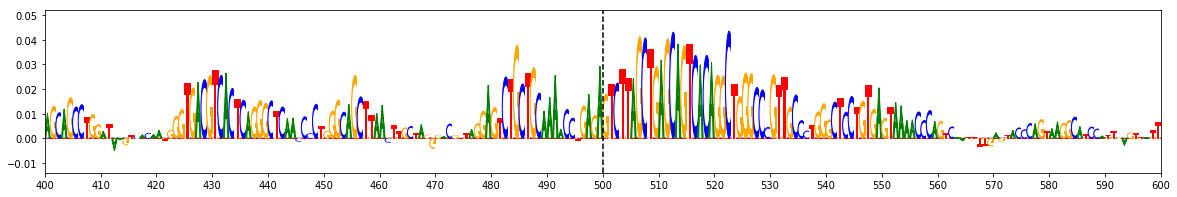

Effect Allele : G   ||   Explain Score : 0.8972   ||   Center / 200bp : 0.4043
Effect Sequence : AAACCTGAGGGTCTTAGCTG


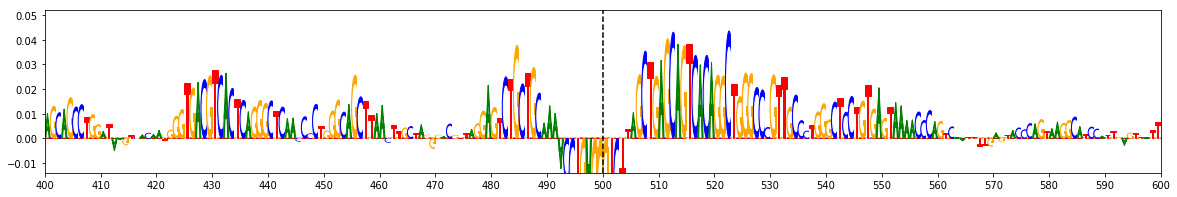

Allele Ratio : 0.7685  ||  Allele Difference : -0.6227  ||  ISM Score : -0.9763  ||  deltaSVM Score : -5.6082


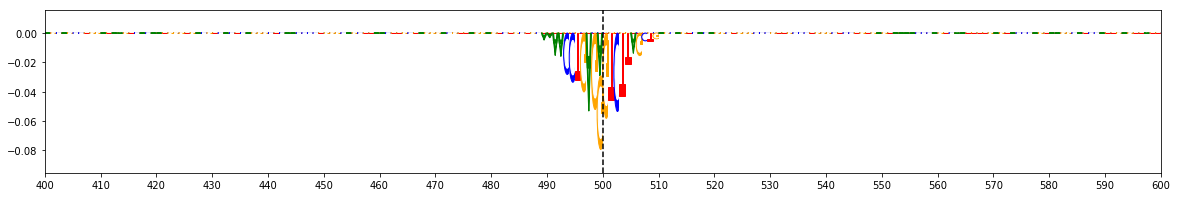


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9014   ||   Center / 200bp : 0.3845
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


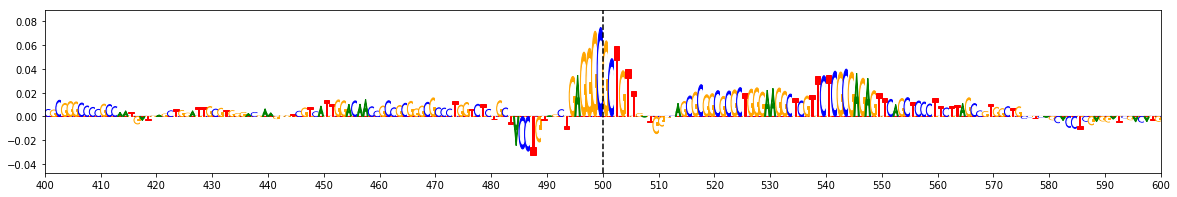

Effect Allele : T   ||   Explain Score : 0.3791   ||   Center / 200bp : 0.2079
Effect Sequence : AGCTGAGGGTGCTGTTGATG


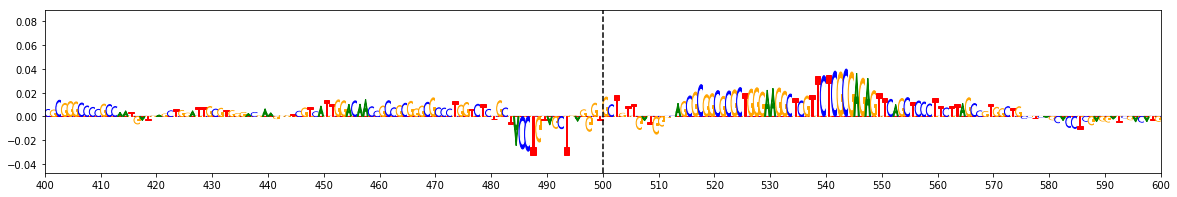

Allele Ratio : 0.4206  ||  Allele Difference : -0.6072  ||  ISM Score : -0.9561  ||  deltaSVM Score : -5.5118


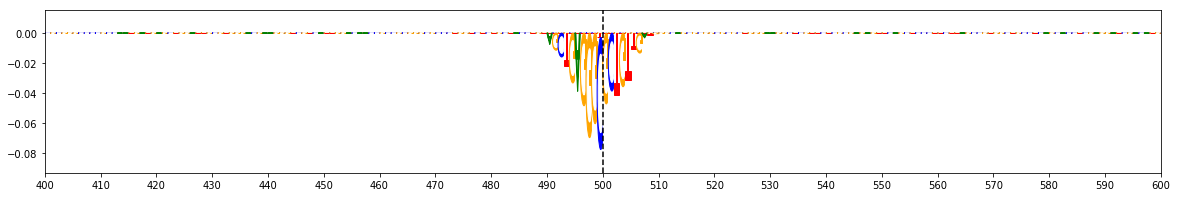


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: 19_44890947   ||    chr19 : 44890946 - 44890947   ||    Locus: 71   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.36E-19

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.231   ||   Center / 200bp : 0.3895
Noneffect Sequence : AGAGGCGGGGCGATGCCTCA


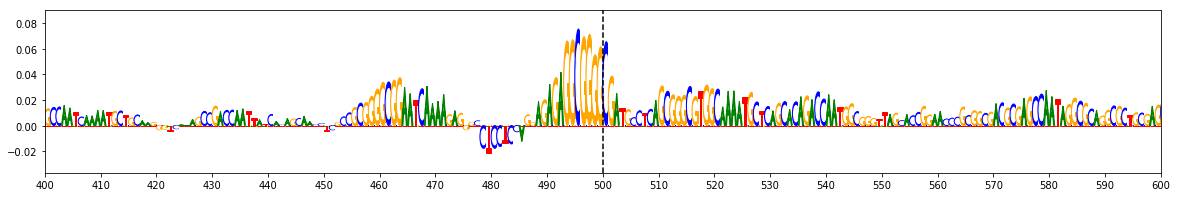

Effect Allele : A   ||   Explain Score : 0.8158   ||   Center / 200bp : 0.2967
Effect Sequence : AGAGGCGGGACGATGCCTCA


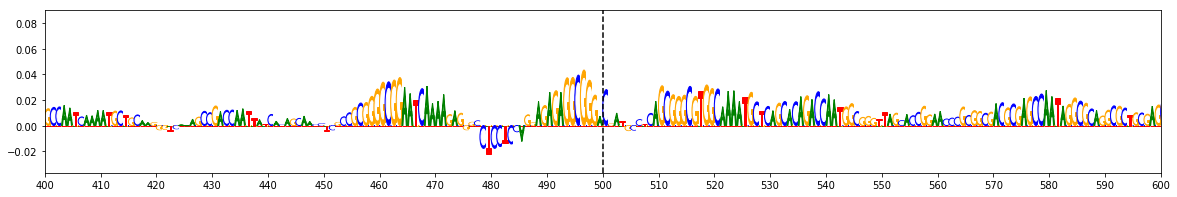

Allele Ratio : 0.6627  ||  Allele Difference : -0.4231  ||  ISM Score : -0.6658  ||  deltaSVM Score : -3.8719


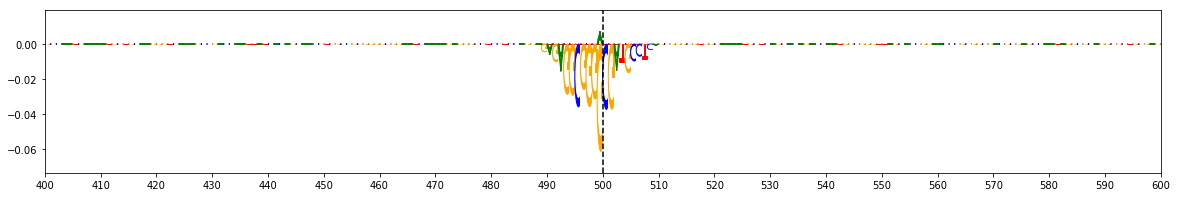


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [10]:
for idx in neg_snps.index:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'],
          '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4),
          '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'],
          '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4),
          '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4),
          ' ||  Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Visualize Top Positive Scoring SNPs <a name='pos_snps' />

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.08E-02
Nalls_23andMe 		  5.08E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.1417   ||  Center / 200bp: 0.1285
Effect Sequence: GGGGCCCCCTGCCGCCCCTC


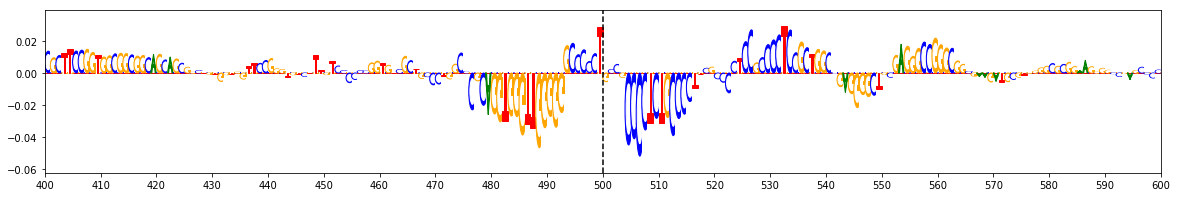

Noneffect Allele: C   ||  Explain Score: 0.0237   ||  Center / 200bp: 0.0248
Noneffect Sequence: GGGGCCCCCCGCCGCCCCTC


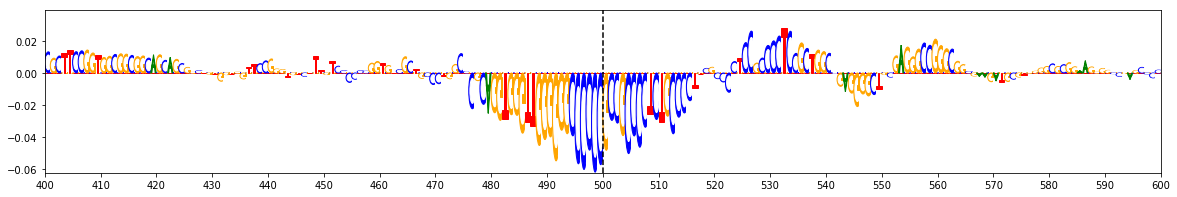

Allele Ratio : 5.9715  ||   Allele Difference : 0.6472  ||  ISM Score : 1.017  ||  deltaSVM Score : 6.7137


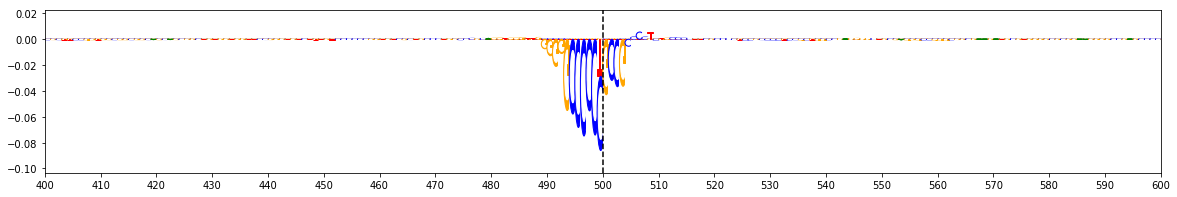


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.79E-167
Alzheimers_Kunkle_2019 		  2.69E-238
Alzheimers_Lambert_2013 	  1.70E-134

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.4882   ||  Center / 200bp: 0.2531
Effect Sequence: AAGCTGGGTAGGGGGCTCTG


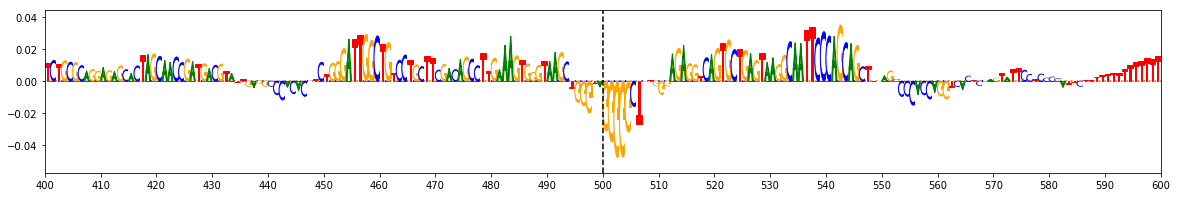

Noneffect Allele: G   ||  Explain Score: 0.4662   ||  Center / 200bp: 0.2446
Noneffect Sequence: AAGCTGGGTGGGGGGCTCTG


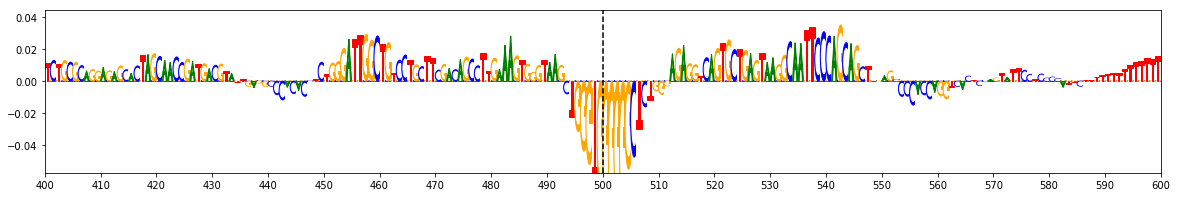

Allele Ratio : 1.0472  ||   Allele Difference : 0.5077  ||  ISM Score : 0.8491  ||  deltaSVM Score : 4.8861


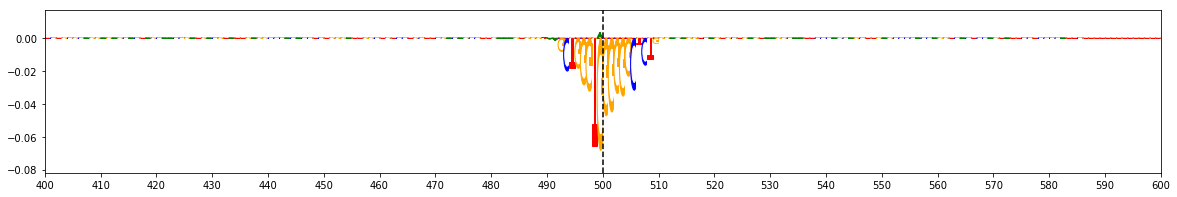


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 16   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.4125   ||  Center / 200bp: 0.5462
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


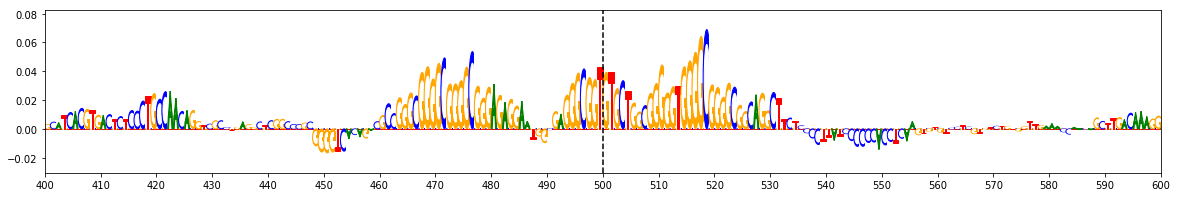

Noneffect Allele: C   ||  Explain Score: 1.0176   ||  Center / 200bp: 0.4648
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


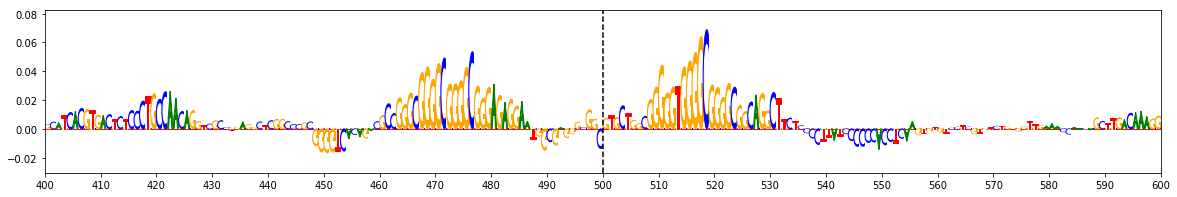

Allele Ratio : 1.3881  ||   Allele Difference : 0.4428  ||  ISM Score : 0.7372  ||  deltaSVM Score : 4.3422


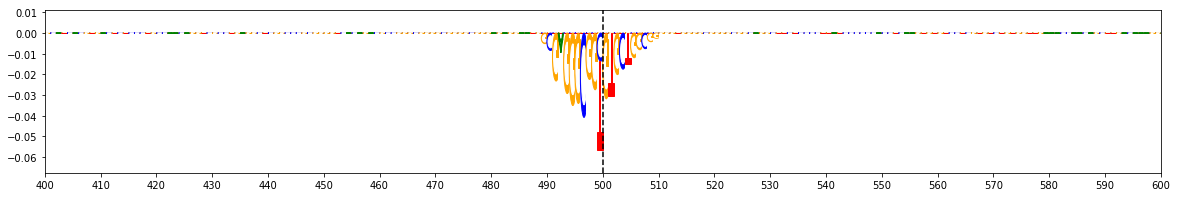


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78555354   ||    chr17 : 45955512 - 45955513   ||    Locus: 54   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.22E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7938   ||  Center / 200bp: 0.4338
Effect Sequence: ACCTCACCCGCCTACAGGTG


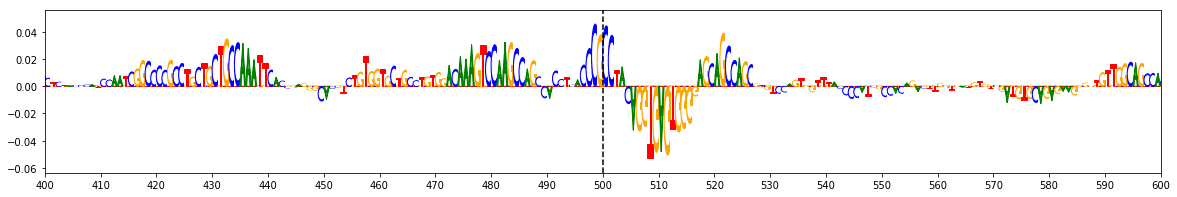

Noneffect Allele: A   ||  Explain Score: 0.5347   ||  Center / 200bp: 0.341
Noneffect Sequence: ACCTCACCCACCTACAGGTG


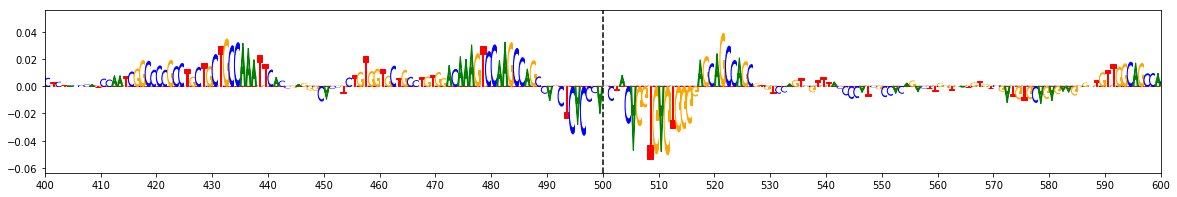

Allele Ratio : 1.4844  ||   Allele Difference : 0.4557  ||  ISM Score : 0.7089  ||  deltaSVM Score : 4.0925


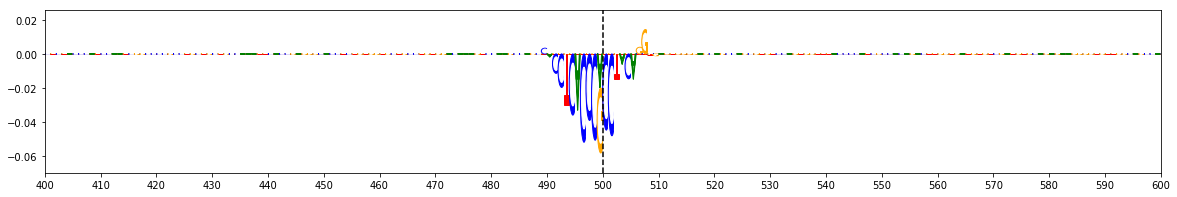


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054811   ||    chr17 : 45841284 - 45841285   ||    Locus: 54   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  8.98E-23

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3289   ||  Center / 200bp: 0.3016
Effect Sequence: TCCCATACCGACCAGTCACT


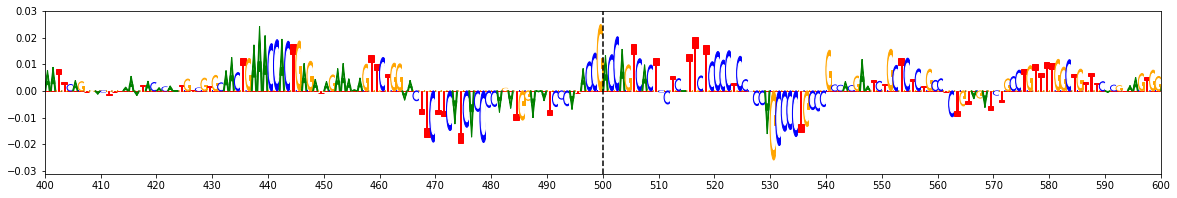

Noneffect Allele: C   ||  Explain Score: 0.1759   ||  Center / 200bp: 0.1877
Noneffect Sequence: TCCCATACCCACCAGTCACT


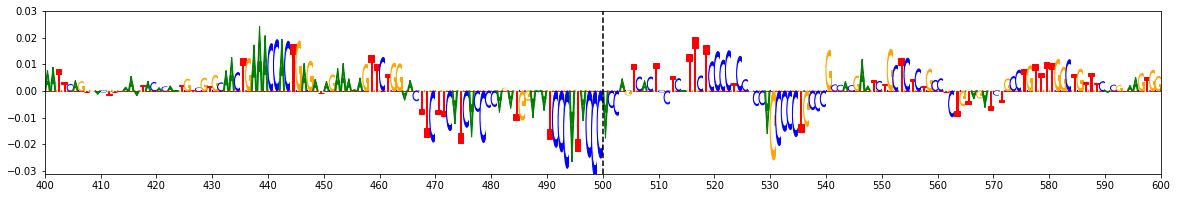

Allele Ratio : 1.8695  ||   Allele Difference : 0.3942  ||  ISM Score : 0.6157  ||  deltaSVM Score : 3.5759


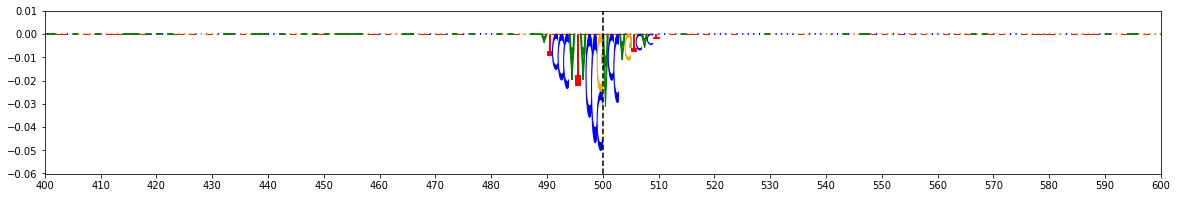


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [11]:
for idx in pos_snps.index:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'],
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'],
          '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4),
          '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
          '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4),
          '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4),
          ' ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Save Significant SNPs

In [12]:
sig_snps = neg_snps.append(pos_snps)
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'+cluster+'.sig.snps.bed',
               sep='\t', index=False)